In [1]:
import numpy as np
from scipy.stats import norm
eps = np.finfo(float).eps

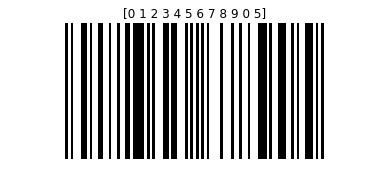

123


In [2]:
%run -i 'generate_barcode.py'
print(np.asarray(stripes).size)

In [3]:
S = len(patterns)
patternLengths = np.zeros(S, dtype=int)
for s in range(S):
    patternLengths[s] = len(patterns[s])

M = 6
C = patternLengths.max()
NumStates = C * S * M

# Enumerate all the states
States = np.zeros((NumStates,3), dtype=int) - 1
StatesInv = np.zeros((C,S,M), dtype=int) - 1    # ix for a spesific c,s,m
ix = 0
for c in range(1,C+1):
    for s in range(S):
        for m in range(1,M+1):
            if (s>4) or (s<=4 and m==1):
                if c <= patternLengths[s]:
                    States[ix,:] = [c,s,m]
                    StatesInv[c-1,s,m-1] = ix
                    ix += 1
NumStates = ix
States = States[0:NumStates, :]
print(States.shape)
# print(StatesInv[0])

(865, 3)


In [4]:
# Part1: Fill the transition matrix A
# mapping states to binaru numbers, which will be useful for computing the likelihood
# c, m 作为下标时 -1
f_kst = np.zeros(NumStates, dtype=int)
A = np.zeros((NumStates,NumStates))

for i in range(NumStates):
    c = States[i,0]
    s = States[i,1]
    m = States[i,2]
    
    patternLen = patternLengths[s]
    f_kst[i] = patterns[s][c-1]    # deternines if this state is black or white
    
    if s==0:    #starting quiet zone
        if c==patternLen:
            for ss in [0,2]:  # The next states can only be either starting quiet zone, or the starting guard
                s_next = ss
                c_next = 1
                m_next = 1
                
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/2
        else:
            c_next = c+1
            s_next = s
            m_next = m
            
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s==1:    # ending quiet zone
        if c==patternLen:
            c_next = 1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s==2:    # starting guard
        if c==patternLen:    # starting the first left digit
            c_next = 1
            m_next = 1
            for ss in range(5,15):
                s_next = ss
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s==3:    # ending guard
        if c==patternLen:
            s_next = 1
            c_next = 1
            m_next = 1
        else:
            c_next = c+1
            s_next = s
            m_next = m
        nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
        A[nextStateIx,i] = 1
    
    elif s==4:    #middle guard
        if c==patternLen:    # starting the first right digit
            c_next = 1
            m_next = 1
            for ss in range(15,25):
                s_next = ss
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
    
    elif s in range(5,15):    # left symbols
        if c==patternLen:    
            c_next = 1
            if m==6:    # end of left digits
                s_next = 4
                m_next = 1
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1
            else:    # starting the next left digit
                m_next = m+1
                for ss in range(5,15):
                    s_next = ss
                    nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                    A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1
            
    elif s in range(15,25):    # right symbols
        if c==patternLen:
            c_next = 1
            if m==6:    # end of right digits
                s_next = 3
                m_next = 1
                nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                A[nextStateIx,i] = 1
            else:    # the next right digit
                m_next = m+1
                for ss in range(15,25):
                    s_next = ss
                    nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
                    A[nextStateIx,i] = 1/10
        else:
            c_next = c+1
            s_next = s
            m_next = m
            nextStateIx = StatesInv[c_next-1,s_next,m_next-1]
            A[nextStateIx,i] = 1

A[A < eps] = eps

In [5]:
# Part2: Compute the initial probability
p_init = np.zeros(NumStates)
# Suppose that the initial probability is a uniform distribution over the
# states with s_n = 0
mask_support_init = States[:, 1] == 0
cnt_support_init = np.sum(mask_support_init)

p_init[mask_support_init] = 1. / cnt_support_init

In [6]:
# Part3: Compute the log-likelihood
T = len(obs)

logObs = np.zeros((NumStates, T))
mu= np.array([250, 20])
sigma = np.array([np.sqrt(5), np.sqrt(5)])

for t in range(0, T):
    # you can use the variable f_kst here
    logObs[:, t] = [norm.logpdf(255 - obs[t], mu[i], sigma[i]) for i in f_kst]

In [7]:
# Question 3: Simulate the HMM and visualize the simulated data.
np.random.seed(1)

p_state = p_init
s_states = np.empty((1, 0), dtype=int)
s_obs = np.empty((1, 0))
state = 0
while state != StatesInv[6, 1, 0]:
    r = np.random.uniform(0, p_state.sum())
    state = np.sum([p_state.cumsum() < r])
    s_states = np.append(s_states, state)
    s_obs = np.append(s_obs, np.random.normal(mu[f_kst[state]], sigma[f_kst[state]]))
    p_state = A[:, state]
s_obs[s_obs < 0] = 0
s_obs[s_obs > 255] = 255

In [8]:
len(s_obs)

107

In [9]:
s_symbols = np.array([States[i, 1] for i in s_states if States[i, 0] == 1])
s_code = s_symbols[s_symbols > 4]
s_code[s_code < 15] -= 5
s_code[s_code > 14] -= 15
s_code

array([1, 8, 4, 5, 2, 5, 9, 5, 0, 0, 7, 9])

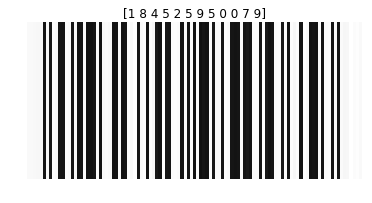

In [10]:
# generate the image
plt.figure()
bc_image = np.tile(s_obs, (50,1))
plt.axis("off")
plt.imshow(bc_image, cmap='gray',vmin=0,vmax=255)
# cmap = 'gray'  : 0-black   1-white
# cmap = 'Grays' : 0-white   1-black
plt.title(str(s_code))
plt.show()

In [11]:
# Part 4: Compute the filtering distribution via Forward recursion
# For numerical stability
p_init[p_init < eps] = eps

# log_alpha: update message in forward pass 
# log_alpha_predict: predict message in forward pass
log_alpha = np.zeros((NumStates, T))
log_alpha_predict = np.zeros((NumStates, T))
for t in range(T):
    if t == 0:
        log_alpha_predict[:, t] = np.log(p_init)
    else:
        mx = np.max(log_alpha[:, t - 1])
        p = np.exp(log_alpha[:, t - 1] - mx)
        log_alpha_predict[:, t] = np.log(A.dot(p)) + mx
    log_alpha[:, t] = log_alpha_predict[:, t] + logObs[:, t]

# d_filtering: filtering distribution
d_filtering = np.zeros((NumStates, T))
for t in range(T):
    alpha = np.exp(log_alpha[:, t])
    d_filtering[:, t] = alpha / np.sum(alpha)

# d_marginal_filtering_s: marginal filtering distribution of s
# d_marginal_filtering_c: marginal filtering distribution of c
# d_marginal_filtering_m: marginal filtering distribution of m
d_marginal_filtering_s = np.zeros((S, T))
d_marginal_filtering_c = np.zeros((C, T))
d_marginal_filtering_m = np.zeros((M, T))
for t in range(T):
    for s in range(S):
        mask_s = [States[:, 1] == s]
        d_marginal_filtering_s[s, t] = np.sum(d_filtering[:, t][mask_s])
    for c in range(C):
        mask_c = [States[:, 0] == c+1]
        d_marginal_filtering_c[c, t] = np.sum(d_filtering[:, t][mask_c])
    for m in range(M):
        mask_m = [States[:, 2] == m+1]
        d_marginal_filtering_m[m, t] = np.sum(d_filtering[:, t][mask_m])

generate_barcode.py:22: RuntimeWarning: invalid value encountered in true_divide
  stripes = stripes + patterns[code[i] + 5]    # get the code for the corresponding left digit


In [12]:
# Part 5: Compute the smoothing distribution via Forward-Backward recursion

# log_beta: update message in backward pass
# log_beta_postdict: postdict message in backward pass
log_beta = np.zeros((NumStates, T))
log_beta_postdict = np.zeros((NumStates, T))
for t in range(T-1,-1,-1):
    if t == T-1:
        log_beta_postdict[:, t] = np.zeros(NumStates)
    else:
        mx = np.max(log_beta[:, t + 1])
        p = np.exp(log_beta[:, t + 1] - mx)
        log_beta_postdict[:, t] = np.log(A.T.dot(p)) + mx
    log_beta[:, t] = log_beta_postdict[:, t] + logObs[:, t]

# d_smoothing: smoothing distribution
d_smoothing = np.zeros((NumStates, T))
for t in range(T):
    gamma = np.exp(log_alpha[:, t] + log_beta_postdict[:, t])
    d_smoothing[:, t] = gamma / np.sum(gamma)

# d_marginal_smoothing_s: marginal smoothing distribution of s
# d_marginal_smoothing_c: marginal smoothing distribution of c
# d_marginal_smoothing_m: marginal smoothing distribution of m
d_marginal_smoothing_s = np.zeros((S, T))
d_marginal_smoothing_c = np.zeros((C, T))
d_marginal_smoothing_m = np.zeros((M, T))
for t in range(T):
    for s in range(S):
        mask_s = [States[:, 1] == s]
        d_marginal_smoothing_s[s, t] = np.sum(d_smoothing[:, t][mask_s])
    for c in range(C):
        mask_c = [States[:, 0] == c+1]
        d_marginal_smoothing_c[c, t] = np.sum(d_smoothing[:, t][mask_c])
    for m in range(M):
        mask_m = [States[:, 2] == m+1]
        d_marginal_smoothing_m[m, t] = np.sum(d_smoothing[:, t][mask_m])

generate_barcode.py:20: RuntimeWarning: invalid value encountered in true_divide
  stripes = stripes + patterns[2]    # initial guard


In [13]:
# Part 6: Compute the most-likely path via Viterbi algorithm

#to be filled
log_beta_viterbi = np.zeros((NumStates, T))
log_beta_postdict_viterbi = np.zeros((NumStates, T))
viterbi_path_b = np.zeros((NumStates, T), dtype=int)
for t in range(T-1,-1,-1):
    if t == T-1:
        log_beta_postdict_viterbi[:, t] = np.zeros(NumStates)
    else:
        mx = np.max(log_beta_viterbi[:, t + 1])
        p = np.exp(log_beta_viterbi[:, t + 1] - mx)
        max_x = [np.max(A.T[i, :] * p) for i in range(NumStates)]
        viterbi_path_b[:, t] = [np.argmax(A.T[i, :] * p) for i in range(NumStates)]
        log_beta_postdict_viterbi[:, t] = np.log(max_x) + mx
    log_beta_viterbi[:, t] = log_beta_postdict_viterbi[:, t] + logObs[:, t]

ml_path_b = np.ones(T, dtype=int) * -1
z = np.argmax(log_beta_viterbi[:, 0])
ml_path_b[0] = z
for t in range(T - 1):
    z = viterbi_path_b[z, t]
    ml_path_b[t+1] = z

ml_path_b

array([  0, 125, 250, 375, 498, 621, 743,   0, 125, 250, 375, 498, 621,
       743,   2, 127, 252,   5, 130, 255, 378, 501, 623, 745,  12, 137,
       262, 385, 508, 630, 752,  19, 144, 269, 392, 515, 637, 759,  26,
       151, 276, 399, 522, 644, 766,  33, 158, 283, 406, 529, 651, 773,
        40, 165, 290, 413, 536, 658, 780,   4, 129, 254, 377, 500, 101,
       226, 351, 474, 597, 719, 841, 108, 233, 358, 481, 604, 726, 848,
       115, 240, 365, 488, 611, 733, 855, 122, 247, 372, 495, 618, 740,
       862,  69, 194, 319, 442, 565, 687, 809, 100, 225, 350, 473, 596,
       718, 840,   3, 128, 253,   1, 126, 251, 376, 499, 622, 744,   1,
       126, 251, 376, 499, 622, 744])

In [14]:
decode_viterbi_b = np.array([States[i, 1] for i in ml_path_b if States[i, 0] == 1])
decode_viterbi_b = decode_viterbi_b[decode_viterbi_b > 4]
decode_viterbi_b[decode_viterbi_b < 15] -= 5
decode_viterbi_b[decode_viterbi_b > 14] -= 15
decode_viterbi_b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 5])

In [15]:
log_alpha_viterbi = np.zeros((NumStates, T))
log_alpha_predict_viterbi = np.zeros((NumStates, T))
viterbi_path_f = np.ones((NumStates, T), dtype=int)
for t in range(T):
    if t == 0:
        log_alpha_predict_viterbi[:, t] = np.log(p_init)
    else:
        mx = np.max(log_alpha_viterbi[:, t - 1])
        p = np.exp(log_alpha_viterbi[:, t - 1] - mx)
        log_alpha_predict_viterbi[:, t] = np.log([np.max(A[i, :] * p) for i in range(NumStates)]) + mx
        viterbi_path_f[:, t] = [np.argmax(A[i, :] * p) for i in range(NumStates)]
    log_alpha_viterbi[:, t] = log_alpha_predict_viterbi[:, t] + logObs[:, t]
    
ml_path_f = np.ones(T, dtype=int) * -1
z = np.argmax(log_alpha_viterbi[:, T-1])
ml_path_f[T - 1] = z
for t in range(T-1,0,-1):
    z = viterbi_path_f[z, t]
    ml_path_f[t - 1] = z

ml_path_f

array([  0, 125, 250, 375, 498, 621, 743,   0, 125, 250, 375, 498, 621,
       743,   2, 127, 252,   5, 130, 255, 378, 501, 623, 745,  12, 137,
       262, 385, 508, 630, 752,  19, 144, 269, 392, 515, 637, 759,  26,
       151, 276, 399, 522, 644, 766,  33, 158, 283, 406, 529, 651, 773,
        40, 165, 290, 413, 536, 658, 780,   4, 129, 254, 377, 500, 101,
       226, 351, 474, 597, 719, 841, 108, 233, 358, 481, 604, 726, 848,
       115, 240, 365, 488, 611, 733, 855, 122, 247, 372, 495, 618, 740,
       862,  69, 194, 319, 442, 565, 687, 809, 100, 225, 350, 473, 596,
       718, 840,   3, 128, 253,   1, 126, 251, 376, 499, 622, 744,   1,
       126, 251, 376, 499, 622, 744])

In [16]:
decode_viterbi_f = np.array([States[i, 1] for i in ml_path_f if States[i, 0] == 1])
decode_viterbi_f = decode_viterbi_f[decode_viterbi_f > 4]
decode_viterbi_f[decode_viterbi_f < 15] -= 5
decode_viterbi_f[decode_viterbi_f > 14] -= 15
decode_viterbi_f

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 5])